# Sciplex Dose

In [1]:
ood_seed = 3

In [2]:
num_ood = 1

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings

In [5]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [7]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

52

In [8]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [9]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [10]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Dex', '5.0'), 694)


Removed datapoint: 694

train         11337
validation     2780
ood             694
Name: split, dtype: int64

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="condition",
    control_group="Vehicle",
    dosage_key="dose_val",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['cell_type']
)

  0%|          | 0/14811 [00:00<?, ?it/s]

 48%|████▊     | 7060/14811 [00:00<00:00, 70589.63it/s]

 96%|█████████▌| 14248/14811 [00:00<00:00, 71343.16it/s]

100%|██████████| 14811/14811 [00:00<00:00, 70740.26it/s]

  0%|          | 0/14811 [00:00<?, ?it/s]

100%|██████████| 14811/14811 [00:00<00:00, 964265.44it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [13]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [14]:
model.train(max_epochs=400)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 170.75it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:03<24:08,  3.63s/it]

Epoch 1/400:   0%|          | 1/400 [00:03<24:08,  3.63s/it, v_num=1, recon=3.12e+3, r2_mean=0.119, adv_loss=1.51, acc_pert=0.319]

Epoch 2/400:   0%|          | 1/400 [00:03<24:08,  3.63s/it, v_num=1, recon=3.12e+3, r2_mean=0.119, adv_loss=1.51, acc_pert=0.319]

Epoch 2/400:   0%|          | 2/400 [00:07<23:05,  3.48s/it, v_num=1, recon=3.12e+3, r2_mean=0.119, adv_loss=1.51, acc_pert=0.319]

Epoch 2/400:   0%|          | 2/400 [00:07<23:05,  3.48s/it, v_num=1, recon=2.37e+3, r2_mean=0.48, adv_loss=1.27, acc_pert=0.488] 

Epoch 3/400:   0%|          | 2/400 [00:07<23:05,  3.48s/it, v_num=1, recon=2.37e+3, r2_mean=0.48, adv_loss=1.27, acc_pert=0.488]

Epoch 3/400:   1%|          | 3/400 [00:10<23:57,  3.62s/it, v_num=1, recon=2.37e+3, r2_mean=0.48, adv_loss=1.27, acc_pert=0.488]

Epoch 3/400:   1%|          | 3/400 [00:10<23:57,  3.62s/it, v_num=1, recon=2.21e+3, r2_mean=0.593, adv_loss=1.15, acc_pert=0.554]

Epoch 4/400:   1%|          | 3/400 [00:10<23:57,  3.62s/it, v_num=1, recon=2.21e+3, r2_mean=0.593, adv_loss=1.15, acc_pert=0.554]

Epoch 4/400:   1%|          | 4/400 [00:14<24:16,  3.68s/it, v_num=1, recon=2.21e+3, r2_mean=0.593, adv_loss=1.15, acc_pert=0.554]

Epoch 4/400:   1%|          | 4/400 [00:14<24:16,  3.68s/it, v_num=1, recon=2.17e+3, r2_mean=0.664, adv_loss=1.06, acc_pert=0.605]

Epoch 5/400:   1%|          | 4/400 [00:14<24:16,  3.68s/it, v_num=1, recon=2.17e+3, r2_mean=0.664, adv_loss=1.06, acc_pert=0.605]

Epoch 5/400:   1%|▏         | 5/400 [00:18<23:42,  3.60s/it, v_num=1, recon=2.17e+3, r2_mean=0.664, adv_loss=1.06, acc_pert=0.605]

Epoch 5/400:   1%|▏         | 5/400 [00:18<23:42,  3.60s/it, v_num=1, recon=2.15e+3, r2_mean=0.711, adv_loss=0.999, acc_pert=0.626]

Epoch 6/400:   1%|▏         | 5/400 [00:18<23:42,  3.60s/it, v_num=1, recon=2.15e+3, r2_mean=0.711, adv_loss=0.999, acc_pert=0.626]

Epoch 6/400:   2%|▏         | 6/400 [00:21<23:51,  3.63s/it, v_num=1, recon=2.15e+3, r2_mean=0.711, adv_loss=0.999, acc_pert=0.626]

Epoch 6/400:   2%|▏         | 6/400 [00:21<23:51,  3.63s/it, v_num=1, recon=2.14e+3, r2_mean=0.746, adv_loss=0.959, acc_pert=0.648]

Epoch 7/400:   2%|▏         | 6/400 [00:21<23:51,  3.63s/it, v_num=1, recon=2.14e+3, r2_mean=0.746, adv_loss=0.959, acc_pert=0.648]

Epoch 7/400:   2%|▏         | 7/400 [00:24<22:59,  3.51s/it, v_num=1, recon=2.14e+3, r2_mean=0.746, adv_loss=0.959, acc_pert=0.648]

Epoch 7/400:   2%|▏         | 7/400 [00:24<22:59,  3.51s/it, v_num=1, recon=2.13e+3, r2_mean=0.77, adv_loss=0.92, acc_pert=0.664]  

Epoch 8/400:   2%|▏         | 7/400 [00:24<22:59,  3.51s/it, v_num=1, recon=2.13e+3, r2_mean=0.77, adv_loss=0.92, acc_pert=0.664]

Epoch 8/400:   2%|▏         | 8/400 [00:28<22:22,  3.42s/it, v_num=1, recon=2.13e+3, r2_mean=0.77, adv_loss=0.92, acc_pert=0.664]

Epoch 8/400:   2%|▏         | 8/400 [00:28<22:22,  3.42s/it, v_num=1, recon=2.12e+3, r2_mean=0.788, adv_loss=0.901, acc_pert=0.674]

Epoch 9/400:   2%|▏         | 8/400 [00:28<22:22,  3.42s/it, v_num=1, recon=2.12e+3, r2_mean=0.788, adv_loss=0.901, acc_pert=0.674]

Epoch 9/400:   2%|▏         | 9/400 [00:31<22:07,  3.40s/it, v_num=1, recon=2.12e+3, r2_mean=0.788, adv_loss=0.901, acc_pert=0.674]

Epoch 9/400:   2%|▏         | 9/400 [00:31<22:07,  3.40s/it, v_num=1, recon=2.12e+3, r2_mean=0.805, adv_loss=0.887, acc_pert=0.675]

Epoch 10/400:   2%|▏         | 9/400 [00:31<22:07,  3.40s/it, v_num=1, recon=2.12e+3, r2_mean=0.805, adv_loss=0.887, acc_pert=0.675]


disnt_basal = 0.4108976256746483

disnt_after = 0.41191963905298773

val_r2_mean = 0.8094846367835998

val_r2_var = 0.26458139148625465


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:52<56:17,  8.66s/it, v_num=1, recon=2.12e+3, r2_mean=0.805, adv_loss=0.887, acc_pert=0.675]

Epoch 10/400:   2%|▎         | 10/400 [00:52<56:17,  8.66s/it, v_num=1, recon=2.11e+3, r2_mean=0.816, adv_loss=0.861, acc_pert=0.685, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:52<56:17,  8.66s/it, v_num=1, recon=2.11e+3, r2_mean=0.816, adv_loss=0.861, acc_pert=0.685, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:55<45:26,  7.01s/it, v_num=1, recon=2.11e+3, r2_mean=0.816, adv_loss=0.861, acc_pert=0.685, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:55<45:26,  7.01s/it, v_num=1, recon=2.11e+3, r2_mean=0.828, adv_loss=0.852, acc_pert=0.688, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:55<45:26,  7.01s/it, v_num=1, recon=2.11e+3, r2_mean=0.828, adv_loss=0.852, acc_pert=0.688, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:58<37:56,  5.87s/it, v_num=1, recon=2.11e+3, r2_mean=0.828, adv_loss=0.852, acc_pert=0.688, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:58<37:56,  5.87s/it, v_num=1, recon=2.11e+3, r2_mean=0.835, adv_loss=0.846, acc_pert=0.691, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:58<37:56,  5.87s/it, v_num=1, recon=2.11e+3, r2_mean=0.835, adv_loss=0.846, acc_pert=0.691, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:01<32:41,  5.07s/it, v_num=1, recon=2.11e+3, r2_mean=0.835, adv_loss=0.846, acc_pert=0.691, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:01<32:41,  5.07s/it, v_num=1, recon=2.1e+3, r2_mean=0.845, adv_loss=0.837, acc_pert=0.692, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan] 

Epoch 14/400:   3%|▎         | 13/400 [01:01<32:41,  5.07s/it, v_num=1, recon=2.1e+3, r2_mean=0.845, adv_loss=0.837, acc_pert=0.692, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:04<28:53,  4.49s/it, v_num=1, recon=2.1e+3, r2_mean=0.845, adv_loss=0.837, acc_pert=0.692, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [01:04<28:53,  4.49s/it, v_num=1, recon=2.1e+3, r2_mean=0.853, adv_loss=0.826, acc_pert=0.702, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [01:04<28:53,  4.49s/it, v_num=1, recon=2.1e+3, r2_mean=0.853, adv_loss=0.826, acc_pert=0.702, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:08<26:21,  4.11s/it, v_num=1, recon=2.1e+3, r2_mean=0.853, adv_loss=0.826, acc_pert=0.702, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [01:08<26:21,  4.11s/it, v_num=1, recon=2.1e+3, r2_mean=0.859, adv_loss=0.822, acc_pert=0.698, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [01:08<26:21,  4.11s/it, v_num=1, recon=2.1e+3, r2_mean=0.859, adv_loss=0.822, acc_pert=0.698, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:11<24:26,  3.82s/it, v_num=1, recon=2.1e+3, r2_mean=0.859, adv_loss=0.822, acc_pert=0.698, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [01:11<24:26,  3.82s/it, v_num=1, recon=2.1e+3, r2_mean=0.863, adv_loss=0.819, acc_pert=0.698, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [01:11<24:26,  3.82s/it, v_num=1, recon=2.1e+3, r2_mean=0.863, adv_loss=0.819, acc_pert=0.698, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:16<27:52,  4.37s/it, v_num=1, recon=2.1e+3, r2_mean=0.863, adv_loss=0.819, acc_pert=0.698, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [01:16<27:52,  4.37s/it, v_num=1, recon=2.09e+3, r2_mean=0.869, adv_loss=0.814, acc_pert=0.7, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan] 

Epoch 18/400:   4%|▍         | 17/400 [01:16<27:52,  4.37s/it, v_num=1, recon=2.09e+3, r2_mean=0.869, adv_loss=0.814, acc_pert=0.7, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:20<25:29,  4.01s/it, v_num=1, recon=2.09e+3, r2_mean=0.869, adv_loss=0.814, acc_pert=0.7, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [01:20<25:29,  4.01s/it, v_num=1, recon=2.09e+3, r2_mean=0.873, adv_loss=0.808, acc_pert=0.705, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [01:20<25:29,  4.01s/it, v_num=1, recon=2.09e+3, r2_mean=0.873, adv_loss=0.808, acc_pert=0.705, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:23<23:55,  3.77s/it, v_num=1, recon=2.09e+3, r2_mean=0.873, adv_loss=0.808, acc_pert=0.705, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:23<23:55,  3.77s/it, v_num=1, recon=2.09e+3, r2_mean=0.876, adv_loss=0.803, acc_pert=0.708, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:23<23:55,  3.77s/it, v_num=1, recon=2.09e+3, r2_mean=0.876, adv_loss=0.803, acc_pert=0.708, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]


disnt_basal = 0.43105851585240934

disnt_after = 0.43210923537695933

val_r2_mean = 0.8744586353952236

val_r2_var = 0.3289552775296298


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:41<51:41,  8.16s/it, v_num=1, recon=2.09e+3, r2_mean=0.876, adv_loss=0.803, acc_pert=0.708, val_recon=2.09e+3, disnt_basal=0.411, disnt_after=0.412, val_r2_mean=0.809, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:41<51:41,  8.16s/it, v_num=1, recon=2.09e+3, r2_mean=0.878, adv_loss=0.799, acc_pert=0.708, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [01:41<51:41,  8.16s/it, v_num=1, recon=2.09e+3, r2_mean=0.878, adv_loss=0.799, acc_pert=0.708, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:46<44:40,  7.07s/it, v_num=1, recon=2.09e+3, r2_mean=0.878, adv_loss=0.799, acc_pert=0.708, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:46<44:40,  7.07s/it, v_num=1, recon=2.08e+3, r2_mean=0.881, adv_loss=0.791, acc_pert=0.712, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:46<44:40,  7.07s/it, v_num=1, recon=2.08e+3, r2_mean=0.881, adv_loss=0.791, acc_pert=0.712, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:50<39:49,  6.32s/it, v_num=1, recon=2.08e+3, r2_mean=0.881, adv_loss=0.791, acc_pert=0.712, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:50<39:49,  6.32s/it, v_num=1, recon=2.08e+3, r2_mean=0.883, adv_loss=0.788, acc_pert=0.715, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:50<39:49,  6.32s/it, v_num=1, recon=2.08e+3, r2_mean=0.883, adv_loss=0.788, acc_pert=0.715, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:54<34:10,  5.44s/it, v_num=1, recon=2.08e+3, r2_mean=0.883, adv_loss=0.788, acc_pert=0.715, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:54<34:10,  5.44s/it, v_num=1, recon=2.08e+3, r2_mean=0.884, adv_loss=0.786, acc_pert=0.712, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:54<34:10,  5.44s/it, v_num=1, recon=2.08e+3, r2_mean=0.884, adv_loss=0.786, acc_pert=0.712, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:57<30:07,  4.81s/it, v_num=1, recon=2.08e+3, r2_mean=0.884, adv_loss=0.786, acc_pert=0.712, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:57<30:07,  4.81s/it, v_num=1, recon=2.08e+3, r2_mean=0.886, adv_loss=0.776, acc_pert=0.723, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:57<30:07,  4.81s/it, v_num=1, recon=2.08e+3, r2_mean=0.886, adv_loss=0.776, acc_pert=0.723, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [02:00<27:13,  4.36s/it, v_num=1, recon=2.08e+3, r2_mean=0.886, adv_loss=0.776, acc_pert=0.723, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [02:00<27:13,  4.36s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.776, acc_pert=0.721, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [02:00<27:13,  4.36s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.776, acc_pert=0.721, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:04<25:09,  4.03s/it, v_num=1, recon=2.07e+3, r2_mean=0.887, adv_loss=0.776, acc_pert=0.721, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [02:04<25:09,  4.03s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.769, acc_pert=0.722, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [02:04<25:09,  4.03s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.769, acc_pert=0.722, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:07<23:56,  3.85s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.769, acc_pert=0.722, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [02:07<23:56,  3.85s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.769, acc_pert=0.722, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [02:07<23:56,  3.85s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.769, acc_pert=0.722, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:10<22:52,  3.69s/it, v_num=1, recon=2.07e+3, r2_mean=0.888, adv_loss=0.769, acc_pert=0.722, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [02:10<22:52,  3.69s/it, v_num=1, recon=2.07e+3, r2_mean=0.89, adv_loss=0.757, acc_pert=0.727, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan] 

Epoch 29/400:   7%|▋         | 28/400 [02:10<22:52,  3.69s/it, v_num=1, recon=2.07e+3, r2_mean=0.89, adv_loss=0.757, acc_pert=0.727, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:14<22:04,  3.57s/it, v_num=1, recon=2.07e+3, r2_mean=0.89, adv_loss=0.757, acc_pert=0.727, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [02:14<22:04,  3.57s/it, v_num=1, recon=2.07e+3, r2_mean=0.89, adv_loss=0.758, acc_pert=0.723, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [02:14<22:04,  3.57s/it, v_num=1, recon=2.07e+3, r2_mean=0.89, adv_loss=0.758, acc_pert=0.723, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]


disnt_basal = 0.43794797824255743

disnt_after = 0.43997130109335175

val_r2_mean = 0.8863845234567471

val_r2_var = 0.354674584757198


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [02:39<1:01:27,  9.97s/it, v_num=1, recon=2.07e+3, r2_mean=0.89, adv_loss=0.758, acc_pert=0.723, val_recon=2.07e+3, disnt_basal=0.431, disnt_after=0.432, val_r2_mean=0.874, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [02:39<1:01:27,  9.97s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.751, acc_pert=0.729, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [02:39<1:01:27,  9.97s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.751, acc_pert=0.729, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [02:42<48:47,  7.93s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.751, acc_pert=0.729, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]  

Epoch 31/400:   8%|▊         | 31/400 [02:42<48:47,  7.93s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.757, acc_pert=0.729, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [02:42<48:47,  7.93s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.757, acc_pert=0.729, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:45<39:52,  6.50s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.757, acc_pert=0.729, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [02:45<39:52,  6.50s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.75, acc_pert=0.727, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [02:45<39:52,  6.50s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.75, acc_pert=0.727, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:48<33:39,  5.50s/it, v_num=1, recon=2.06e+3, r2_mean=0.891, adv_loss=0.75, acc_pert=0.727, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:48<33:39,  5.50s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.754, acc_pert=0.731, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:48<33:39,  5.50s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.754, acc_pert=0.731, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:51<29:25,  4.83s/it, v_num=1, recon=2.06e+3, r2_mean=0.892, adv_loss=0.754, acc_pert=0.731, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:51<29:25,  4.83s/it, v_num=1, recon=2.06e+3, r2_mean=0.893, adv_loss=0.744, acc_pert=0.73, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan] 

Epoch 35/400:   8%|▊         | 34/400 [02:51<29:25,  4.83s/it, v_num=1, recon=2.06e+3, r2_mean=0.893, adv_loss=0.744, acc_pert=0.73, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:55<26:25,  4.34s/it, v_num=1, recon=2.06e+3, r2_mean=0.893, adv_loss=0.744, acc_pert=0.73, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:55<26:25,  4.34s/it, v_num=1, recon=2.06e+3, r2_mean=0.893, adv_loss=0.748, acc_pert=0.729, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [02:55<26:25,  4.34s/it, v_num=1, recon=2.06e+3, r2_mean=0.893, adv_loss=0.748, acc_pert=0.729, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:58<24:16,  4.00s/it, v_num=1, recon=2.06e+3, r2_mean=0.893, adv_loss=0.748, acc_pert=0.729, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:58<24:16,  4.00s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.743, acc_pert=0.735, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:58<24:16,  4.00s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.743, acc_pert=0.735, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [03:01<22:42,  3.75s/it, v_num=1, recon=2.05e+3, r2_mean=0.893, adv_loss=0.743, acc_pert=0.735, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [03:01<22:42,  3.75s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.738, acc_pert=0.736, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [03:01<22:42,  3.75s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.738, acc_pert=0.736, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:04<21:37,  3.58s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.738, acc_pert=0.736, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [03:04<21:37,  3.58s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.736, acc_pert=0.735, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [03:04<21:37,  3.58s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.736, acc_pert=0.735, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:08<22:48,  3.79s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.736, acc_pert=0.735, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [03:08<22:48,  3.79s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.745, acc_pert=0.733, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [03:08<22:48,  3.79s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.745, acc_pert=0.733, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]


disnt_basal = 0.4346270530051358

disnt_after = 0.43675215185932964

val_r2_mean = 0.8848863796754316

val_r2_var = 0.37230967066504744


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [03:27<50:06,  8.35s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.745, acc_pert=0.733, val_recon=2.05e+3, disnt_basal=0.438, disnt_after=0.44, val_r2_mean=0.886, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [03:27<50:06,  8.35s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.735, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [03:27<50:06,  8.35s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.735, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:31<41:17,  6.90s/it, v_num=1, recon=2.05e+3, r2_mean=0.894, adv_loss=0.735, acc_pert=0.739, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [03:31<41:17,  6.90s/it, v_num=1, recon=2.05e+3, r2_mean=0.895, adv_loss=0.735, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [03:31<41:17,  6.90s/it, v_num=1, recon=2.05e+3, r2_mean=0.895, adv_loss=0.735, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:34<34:57,  5.86s/it, v_num=1, recon=2.05e+3, r2_mean=0.895, adv_loss=0.735, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [03:34<34:57,  5.86s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.731, acc_pert=0.736, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [03:34<34:57,  5.86s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.731, acc_pert=0.736, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:38<30:25,  5.11s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.731, acc_pert=0.736, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [03:38<30:25,  5.11s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.733, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [03:38<30:25,  5.11s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.733, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:41<27:12,  4.59s/it, v_num=1, recon=2.04e+3, r2_mean=0.895, adv_loss=0.733, acc_pert=0.737, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [03:41<27:12,  4.59s/it, v_num=1, recon=2.04e+3, r2_mean=0.897, adv_loss=0.726, acc_pert=0.741, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [03:41<27:12,  4.59s/it, v_num=1, recon=2.04e+3, r2_mean=0.897, adv_loss=0.726, acc_pert=0.741, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:44<24:59,  4.23s/it, v_num=1, recon=2.04e+3, r2_mean=0.897, adv_loss=0.726, acc_pert=0.741, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [03:44<24:59,  4.23s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.727, acc_pert=0.738, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [03:44<24:59,  4.23s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.727, acc_pert=0.738, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:48<23:16,  3.95s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.727, acc_pert=0.738, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [03:48<23:16,  3.95s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.734, acc_pert=0.735, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [03:48<23:16,  3.95s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.734, acc_pert=0.735, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:51<22:03,  3.75s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.734, acc_pert=0.735, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [03:51<22:03,  3.75s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.736, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [03:51<22:03,  3.75s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.736, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:54<21:18,  3.63s/it, v_num=1, recon=2.04e+3, r2_mean=0.896, adv_loss=0.736, acc_pert=0.734, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [03:54<21:18,  3.63s/it, v_num=1, recon=2.04e+3, r2_mean=0.897, adv_loss=0.72, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan] 

Epoch 49/400:  12%|█▏        | 48/400 [03:54<21:18,  3.63s/it, v_num=1, recon=2.04e+3, r2_mean=0.897, adv_loss=0.72, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:58<20:36,  3.52s/it, v_num=1, recon=2.04e+3, r2_mean=0.897, adv_loss=0.72, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [03:58<20:36,  3.52s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.719, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [03:58<20:36,  3.52s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.719, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]


disnt_basal = 0.4343092164187272

disnt_after = 0.43643966359038927

val_r2_mean = 0.8943525899540297

val_r2_var = 0.375952037897977


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [04:19<51:51,  8.89s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.719, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.435, disnt_after=0.437, val_r2_mean=0.885, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [04:19<51:51,  8.89s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.723, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan] 

Epoch 51/400:  12%|█▎        | 50/400 [04:19<51:51,  8.89s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.723, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:22<41:50,  7.19s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.723, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [04:22<41:50,  7.19s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.719, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [04:22<41:50,  7.19s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.719, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:25<34:49,  6.01s/it, v_num=1, recon=2.03e+3, r2_mean=0.897, adv_loss=0.719, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [04:25<34:49,  6.01s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [04:25<34:49,  6.01s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:29<30:06,  5.20s/it, v_num=1, recon=2.03e+3, r2_mean=0.896, adv_loss=0.721, acc_pert=0.742, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [04:29<30:06,  5.20s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.714, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [04:29<30:06,  5.20s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.714, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:32<26:38,  4.62s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.714, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [04:32<26:38,  4.62s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.716, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [04:32<26:38,  4.62s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.716, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:35<24:11,  4.21s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.716, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [04:35<24:11,  4.21s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.715, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan] 

Epoch 56/400:  14%|█▍        | 55/400 [04:35<24:11,  4.21s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.715, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:39<22:28,  3.92s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.715, acc_pert=0.74, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [04:39<22:28,  3.92s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.717, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [04:39<22:28,  3.92s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.717, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:42<21:17,  3.72s/it, v_num=1, recon=2.03e+3, r2_mean=0.898, adv_loss=0.717, acc_pert=0.744, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [04:42<21:17,  3.72s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.716, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [04:42<21:17,  3.72s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.716, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:45<20:27,  3.59s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.716, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [04:45<20:27,  3.59s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [04:45<20:27,  3.59s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:48<19:51,  3.50s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.711, acc_pert=0.745, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [04:48<19:51,  3.50s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.715, acc_pert=0.741, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [04:48<19:51,  3.50s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.715, acc_pert=0.741, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.4304897849303559

disnt_after = 0.432259671294001

val_r2_mean = 0.892012366923419

val_r2_var = 0.39982561794194305


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [05:07<44:59,  7.94s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.715, acc_pert=0.741, val_recon=2.04e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.894, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [05:07<44:59,  7.94s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.715, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]  

Epoch 61/400:  15%|█▌        | 60/400 [05:07<44:59,  7.94s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.715, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:10<37:30,  6.64s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.715, acc_pert=0.74, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [05:10<37:30,  6.64s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [05:10<37:30,  6.64s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:14<31:44,  5.64s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [05:14<31:44,  5.64s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [05:14<31:44,  5.64s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:17<27:47,  4.95s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.707, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [05:17<27:47,  4.95s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.712, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [05:17<27:47,  4.95s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.712, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:20<25:02,  4.47s/it, v_num=1, recon=2.02e+3, r2_mean=0.899, adv_loss=0.712, acc_pert=0.744, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [05:20<25:02,  4.47s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [05:20<25:02,  4.47s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:24<23:00,  4.12s/it, v_num=1, recon=2.02e+3, r2_mean=0.898, adv_loss=0.706, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [05:24<23:00,  4.12s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.709, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]  

Epoch 66/400:  16%|█▋        | 65/400 [05:24<23:00,  4.12s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.709, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:27<21:26,  3.85s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.709, acc_pert=0.748, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [05:27<21:26,  3.85s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [05:27<21:26,  3.85s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:30<20:25,  3.68s/it, v_num=1, recon=2.01e+3, r2_mean=0.898, adv_loss=0.702, acc_pert=0.745, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [05:30<20:25,  3.68s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.715, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]  

Epoch 68/400:  17%|█▋        | 67/400 [05:30<20:25,  3.68s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.715, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:33<19:46,  3.57s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.715, acc_pert=0.743, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [05:33<19:46,  3.57s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.702, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [05:33<19:46,  3.57s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.702, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:37<19:15,  3.49s/it, v_num=1, recon=2.01e+3, r2_mean=0.899, adv_loss=0.702, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [05:37<19:15,  3.49s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]  

Epoch 70/400:  17%|█▋        | 69/400 [05:37<19:15,  3.49s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.43372092029502446

disnt_after = 0.43693543244482563

val_r2_mean = 0.8930463167754087

val_r2_var = 0.4048258060758764


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [05:58<48:27,  8.81s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.706, acc_pert=0.746, val_recon=2.03e+3, disnt_basal=0.43, disnt_after=0.432, val_r2_mean=0.892, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [05:58<48:27,  8.81s/it, v_num=1, recon=2.01e+3, r2_mean=0.901, adv_loss=0.705, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [05:58<48:27,  8.81s/it, v_num=1, recon=2.01e+3, r2_mean=0.901, adv_loss=0.705, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:01<39:24,  7.19s/it, v_num=1, recon=2.01e+3, r2_mean=0.901, adv_loss=0.705, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [06:01<39:24,  7.19s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.707, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]  

Epoch 72/400:  18%|█▊        | 71/400 [06:01<39:24,  7.19s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.707, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:05<33:07,  6.06s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.707, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [06:05<33:07,  6.06s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.702, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [06:05<33:07,  6.06s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.702, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:08<28:32,  5.24s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.702, acc_pert=0.747, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [06:08<28:32,  5.24s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.699, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [06:08<28:32,  5.24s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.699, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:11<25:17,  4.66s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.699, acc_pert=0.749, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [06:11<25:17,  4.66s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.698, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan] 

Epoch 75/400:  18%|█▊        | 74/400 [06:11<25:17,  4.66s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.698, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:15<23:00,  4.25s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.698, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [06:15<23:00,  4.25s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.692, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [06:15<23:00,  4.25s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.692, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:18<21:27,  3.97s/it, v_num=1, recon=2.01e+3, r2_mean=0.9, adv_loss=0.692, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [06:18<21:27,  3.97s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]   

Epoch 77/400:  19%|█▉        | 76/400 [06:18<21:27,  3.97s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:21<20:14,  3.76s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.697, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [06:21<20:14,  3.76s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.701, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [06:21<20:14,  3.76s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.701, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:25<19:26,  3.62s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.701, acc_pert=0.75, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [06:25<19:26,  3.62s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.692, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan] 

Epoch 79/400:  20%|█▉        | 78/400 [06:25<19:26,  3.62s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.692, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:28<18:49,  3.52s/it, v_num=1, recon=2e+3, r2_mean=0.9, adv_loss=0.692, acc_pert=0.752, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [06:28<18:49,  3.52s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.697, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [06:28<18:49,  3.52s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.697, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.43537026952408026

disnt_after = 0.437744394871083

val_r2_mean = 0.889960972287438

val_r2_var = 0.4117350767959248

Epoch 80/400:  20%|██        | 80/400 [06:49<47:35,  8.92s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.697, acc_pert=0.751, val_recon=2.03e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.893, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [06:49<47:35,  8.92s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.689, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [06:49<47:35,  8.92s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.689, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:53<38:33,  7.25s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.689, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [06:53<38:33,  7.25s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.701, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [06:53<38:33,  7.25s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.701, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:56<32:25,  6.12s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.701, acc_pert=0.748, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [06:56<32:25,  6.12s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.69, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]  

Epoch 83/400:  20%|██        | 82/400 [06:56<32:25,  6.12s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.69, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:00<28:03,  5.31s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.69, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [07:00<28:03,  5.31s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.688, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [07:00<28:03,  5.31s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.688, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:03<25:02,  4.75s/it, v_num=1, recon=2e+3, r2_mean=0.901, adv_loss=0.688, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [07:03<25:02,  4.75s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.689, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [07:03<25:02,  4.75s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.689, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:07<22:50,  4.35s/it, v_num=1, recon=2e+3, r2_mean=0.902, adv_loss=0.689, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [07:07<22:50,  4.35s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.688, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [07:07<22:50,  4.35s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.688, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:10<21:11,  4.05s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.688, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [07:10<21:11,  4.05s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [07:10<21:11,  4.05s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:13<20:07,  3.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.687, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [07:13<20:07,  3.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.693, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan] 

Epoch 88/400:  22%|██▏       | 87/400 [07:13<20:07,  3.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.693, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:17<19:10,  3.69s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.693, acc_pert=0.75, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [07:17<19:10,  3.69s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.693, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [07:17<19:10,  3.69s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.693, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:20<18:30,  3.57s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.693, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [07:20<18:30,  3.57s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.681, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [07:20<18:30,  3.57s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.681, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.43162921641589735

disnt_after = 0.4340213883851307

val_r2_mean = 0.8902578527277167

val_r2_var = 0.4216450783339415


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [07:37<39:32,  7.65s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.681, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.435, disnt_after=0.438, val_r2_mean=0.89, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [07:37<39:32,  7.65s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.69, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan] 

Epoch 91/400:  22%|██▎       | 90/400 [07:37<39:32,  7.65s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.69, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:40<32:52,  6.38s/it, v_num=1, recon=1.99e+3, r2_mean=0.901, adv_loss=0.69, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [07:40<32:52,  6.38s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.692, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [07:40<32:52,  6.38s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.692, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:44<28:09,  5.49s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.692, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [07:44<28:09,  5.49s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [07:44<28:09,  5.49s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:47<24:51,  4.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [07:47<24:51,  4.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.679, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [07:47<24:51,  4.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.679, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:51<22:34,  4.43s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.679, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [07:51<22:34,  4.43s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.682, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [07:51<22:34,  4.43s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.682, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [07:54<20:47,  4.09s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.682, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [07:54<20:47,  4.09s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.682, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [07:54<20:47,  4.09s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.682, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [07:57<19:33,  3.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.682, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [07:57<19:33,  3.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.685, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [07:57<19:33,  3.86s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.685, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:01<18:41,  3.70s/it, v_num=1, recon=1.99e+3, r2_mean=0.903, adv_loss=0.685, acc_pert=0.751, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [08:01<18:41,  3.70s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.683, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [08:01<18:41,  3.70s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.683, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:04<18:01,  3.58s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.683, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [08:04<18:01,  3.58s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [08:04<18:01,  3.58s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:07<17:30,  3.49s/it, v_num=1, recon=1.99e+3, r2_mean=0.902, adv_loss=0.686, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [08:07<17:30,  3.49s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.677, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [08:07<17:30,  3.49s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.677, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.4339854949326174

disnt_after = 0.4364560515203633

val_r2_mean = 0.8980171848427166

val_r2_var = 0.4209095949476415


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [08:29<44:52,  8.98s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.677, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.432, disnt_after=0.434, val_r2_mean=0.89, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [08:29<44:52,  8.98s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.684, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [08:29<44:52,  8.98s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.684, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:33<36:43,  7.37s/it, v_num=1, recon=1.98e+3, r2_mean=0.901, adv_loss=0.684, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [08:33<36:43,  7.37s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.681, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [08:33<36:43,  7.37s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.681, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:36<30:32,  6.15s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.681, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [08:36<30:32,  6.15s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.68, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan] 

Epoch 103/400:  26%|██▌       | 102/400 [08:36<30:32,  6.15s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.68, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:39<26:13,  5.30s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.68, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [08:39<26:13,  5.30s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.685, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [08:39<26:13,  5.30s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.685, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:43<23:16,  4.72s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.685, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [08:43<23:16,  4.72s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.679, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [08:43<23:16,  4.72s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.679, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:46<21:20,  4.34s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.679, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [08:46<21:20,  4.34s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.674, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [08:46<21:20,  4.34s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.674, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:49<19:38,  4.01s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.674, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [08:49<19:38,  4.01s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.675, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [08:49<19:38,  4.01s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.675, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:53<18:30,  3.79s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.675, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [08:53<18:30,  3.79s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [08:53<18:30,  3.79s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:56<17:41,  3.64s/it, v_num=1, recon=1.98e+3, r2_mean=0.903, adv_loss=0.674, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [08:56<17:41,  3.64s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [08:56<17:41,  3.64s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [08:59<17:11,  3.54s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [08:59<17:11,  3.54s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.672, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [08:59<17:11,  3.54s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.672, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.434281149614625

disnt_after = 0.4367427199605405

val_r2_mean = 0.8960648233240299

val_r2_var = 0.4200732393698258

Epoch 110/400:  28%|██▊       | 110/400 [09:27<51:51, 10.73s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.672, acc_pert=0.753, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.436, val_r2_mean=0.898, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [09:27<51:51, 10.73s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.672, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [09:27<51:51, 10.73s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.672, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:30<41:05,  8.53s/it, v_num=1, recon=1.98e+3, r2_mean=0.902, adv_loss=0.672, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [09:30<41:05,  8.53s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [09:30<41:05,  8.53s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:33<33:31,  6.98s/it, v_num=1, recon=1.98e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [09:33<33:31,  6.98s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.669, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [09:33<33:31,  6.98s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.669, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:37<28:08,  5.88s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.669, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [09:37<28:08,  5.88s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.675, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [09:37<28:08,  5.88s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.675, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:40<24:22,  5.11s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.675, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [09:40<24:22,  5.11s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.678, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [09:40<24:22,  5.11s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.678, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:45<23:59,  5.05s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.678, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [09:45<23:59,  5.05s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.675, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [09:45<23:59,  5.05s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.675, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:48<21:26,  4.53s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.675, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [09:48<21:26,  4.53s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [09:48<21:26,  4.53s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:52<19:35,  4.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [09:52<19:35,  4.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [09:52<19:35,  4.15s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:55<18:21,  3.91s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.673, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [09:55<18:21,  3.91s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan] 

Epoch 119/400:  30%|██▉       | 118/400 [09:55<18:21,  3.91s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:58<17:34,  3.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [09:58<17:34,  3.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.668, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [09:58<17:34,  3.75s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.668, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4383767077319521

disnt_after = 0.44124704212533566

val_r2_mean = 0.8936707664619792

val_r2_var = 0.4254562459208749

Epoch 120/400:  30%|███       | 120/400 [10:15<36:05,  7.74s/it, v_num=1, recon=1.97e+3, r2_mean=0.903, adv_loss=0.668, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.434, disnt_after=0.437, val_r2_mean=0.896, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [10:15<36:05,  7.74s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan] 

Epoch 121/400:  30%|███       | 120/400 [10:15<36:05,  7.74s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:19<30:03,  6.46s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [10:19<30:03,  6.46s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.678, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [10:19<30:03,  6.46s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.678, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:22<25:35,  5.52s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.678, acc_pert=0.752, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [10:22<25:35,  5.52s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [10:22<25:35,  5.52s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:26<22:32,  4.88s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.666, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [10:26<22:32,  4.88s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [10:26<22:32,  4.88s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:29<20:21,  4.43s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [10:29<20:21,  4.43s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.677, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [10:29<20:21,  4.43s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.677, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:32<18:46,  4.10s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.677, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [10:32<18:46,  4.10s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [10:32<18:46,  4.10s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:36<17:45,  3.89s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.67, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [10:36<17:45,  3.89s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [10:36<17:45,  3.89s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:39<17:31,  3.85s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.665, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [10:39<17:31,  3.85s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.674, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [10:39<17:31,  3.85s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.674, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:43<16:45,  3.70s/it, v_num=1, recon=1.97e+3, r2_mean=0.904, adv_loss=0.674, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [10:43<16:45,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.669, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [10:43<16:45,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.669, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:46<16:13,  3.59s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.669, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [10:46<16:13,  3.59s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.664, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [10:46<16:13,  3.59s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.664, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.42994532560215787

disnt_after = 0.4331941443317541

val_r2_mean = 0.8920438040386549

val_r2_var = 0.43104783350771125

Epoch 130/400:  32%|███▎      | 130/400 [11:06<38:45,  8.61s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.664, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.438, disnt_after=0.441, val_r2_mean=0.894, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [11:06<38:45,  8.61s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.671, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan] 

Epoch 131/400:  32%|███▎      | 130/400 [11:06<38:45,  8.61s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.671, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:10<31:47,  7.09s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.671, acc_pert=0.756, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [11:10<31:47,  7.09s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.666, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [11:10<31:47,  7.09s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.666, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:16<30:07,  6.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.666, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [11:16<30:07,  6.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan] 

Epoch 133/400:  33%|███▎      | 132/400 [11:16<30:07,  6.74s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:19<25:22,  5.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [11:19<25:22,  5.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.667, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [11:19<25:22,  5.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.667, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:22<22:02,  4.97s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.667, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [11:22<22:02,  4.97s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [11:22<22:02,  4.97s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:26<19:48,  4.49s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [11:26<19:48,  4.49s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [11:26<19:48,  4.49s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:29<18:09,  4.13s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.755, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [11:29<18:09,  4.13s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [11:29<18:09,  4.13s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:32<16:57,  3.87s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [11:32<16:57,  3.87s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.663, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [11:32<16:57,  3.87s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.663, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [11:36<16:08,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.663, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [11:36<16:08,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [11:36<16:08,  3.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [11:39<15:28,  3.56s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [11:39<15:28,  3.56s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [11:39<15:28,  3.56s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]


disnt_basal = 0.4274475648668838

disnt_after = 0.43110870791894434

val_r2_mean = 0.8962026753208854

val_r2_var = 0.42626379132270814


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [12:04<42:58,  9.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.43, disnt_after=0.433, val_r2_mean=0.892, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [12:04<42:58,  9.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [12:04<42:58,  9.92s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:08<35:09,  8.15s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.665, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [12:08<35:09,  8.15s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.671, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [12:08<35:09,  8.15s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.671, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:11<28:48,  6.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.904, adv_loss=0.671, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [12:11<28:48,  6.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan] 

Epoch 143/400:  36%|███▌      | 142/400 [12:11<28:48,  6.70s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:14<24:21,  5.69s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [12:14<24:21,  5.69s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [12:14<24:21,  5.69s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:18<21:14,  4.98s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.662, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [12:18<21:14,  4.98s/it, v_num=1, recon=1.96e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [12:18<21:14,  4.98s/it, v_num=1, recon=1.96e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [12:21<19:05,  4.49s/it, v_num=1, recon=1.96e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [12:21<19:05,  4.49s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan] 

Epoch 146/400:  36%|███▋      | 145/400 [12:21<19:05,  4.49s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:24<17:40,  4.18s/it, v_num=1, recon=1.96e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [12:24<17:40,  4.18s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.655, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [12:24<17:40,  4.18s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.655, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:28<16:32,  3.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.655, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [12:28<16:32,  3.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [12:28<16:32,  3.92s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:31<15:46,  3.75s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [12:31<15:46,  3.75s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.659, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan] 

Epoch 149/400:  37%|███▋      | 148/400 [12:31<15:46,  3.75s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.659, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:34<15:12,  3.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.659, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [12:34<15:12,  3.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.661, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [12:34<15:12,  3.63s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.661, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4276339121646215

disnt_after = 0.43068402848236925

val_r2_mean = 0.88990233594721

val_r2_var = 0.44537028074264523


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [12:51<31:33,  7.57s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.661, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.431, val_r2_mean=0.896, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [12:51<31:33,  7.57s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.662, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]  

Epoch 151/400:  38%|███▊      | 150/400 [12:51<31:33,  7.57s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.662, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [12:55<26:07,  6.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.662, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [12:55<26:07,  6.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.665, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [12:55<26:07,  6.29s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.665, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [12:58<22:24,  5.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.665, acc_pert=0.754, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [12:58<22:24,  5.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.66, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan] 

Epoch 153/400:  38%|███▊      | 152/400 [12:58<22:24,  5.42s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.66, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [13:01<19:49,  4.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.66, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [13:01<19:49,  4.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [13:01<19:49,  4.82s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:05<17:55,  4.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [13:05<17:55,  4.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.665, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [13:05<17:55,  4.37s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.665, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:08<16:35,  4.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.665, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [13:08<16:35,  4.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.655, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [13:08<16:35,  4.06s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.655, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:11<15:37,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.655, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [13:11<15:37,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [13:11<15:37,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:15<14:52,  3.67s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [13:15<14:52,  3.67s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [13:15<14:52,  3.67s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:18<14:20,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [13:18<14:20,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan] 

Epoch 159/400:  40%|███▉      | 158/400 [13:18<14:20,  3.56s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:21<13:54,  3.46s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.66, acc_pert=0.757, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [13:21<13:54,  3.46s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [13:21<13:54,  3.46s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]


disnt_basal = 0.4268320680787488

disnt_after = 0.4300876587618982

val_r2_mean = 0.8956864860924807

val_r2_var = 0.42325529835440906

Epoch 160/400:  40%|████      | 160/400 [13:35<26:45,  6.69s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.656, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.428, disnt_after=0.431, val_r2_mean=0.89, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [13:35<26:45,  6.69s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.655, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [13:35<26:45,  6.69s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.655, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [13:39<22:33,  5.66s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.655, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [13:39<22:33,  5.66s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [13:39<22:33,  5.66s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [13:42<19:35,  4.94s/it, v_num=1, recon=1.95e+3, r2_mean=0.905, adv_loss=0.661, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [13:42<19:35,  4.94s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.65, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan] 

Epoch 163/400:  40%|████      | 162/400 [13:42<19:35,  4.94s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.65, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [13:45<17:24,  4.41s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.65, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [13:45<17:24,  4.41s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [13:45<17:24,  4.41s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [13:48<15:53,  4.04s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [13:48<15:53,  4.04s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.659, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [13:48<15:53,  4.04s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.659, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [13:52<15:01,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.907, adv_loss=0.659, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [13:52<15:01,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [13:52<15:01,  3.84s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [13:55<14:20,  3.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [13:55<14:20,  3.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [13:55<14:20,  3.68s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [14:01<16:55,  4.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [14:01<16:55,  4.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [14:01<16:55,  4.36s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [14:04<15:37,  4.04s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [14:04<15:37,  4.04s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [14:04<15:37,  4.04s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [14:07<14:37,  3.80s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [14:07<14:37,  3.80s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [14:07<14:37,  3.80s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.42302218619083914

disnt_after = 0.4262889198040451

val_r2_mean = 0.8986739695072175

val_r2_var = 0.429201576384631


Epoch 00169: cpa_metric reached. Module best state updated.


Epoch 170/400:  42%|████▎     | 170/400 [14:38<45:01, 11.74s/it, v_num=1, recon=1.95e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.427, disnt_after=0.43, val_r2_mean=0.896, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [14:38<45:01, 11.74s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.655, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [14:38<45:01, 11.74s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.655, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [14:42<36:33,  9.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.655, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [14:42<36:33,  9.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [14:42<36:33,  9.58s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [14:45<29:13,  7.69s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.654, acc_pert=0.758, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [14:45<29:13,  7.69s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [14:45<29:13,  7.69s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [14:49<24:05,  6.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.656, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [14:49<24:05,  6.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.657, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [14:49<24:05,  6.37s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.657, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [14:52<20:30,  5.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.657, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [14:52<20:30,  5.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan] 

Epoch 175/400:  44%|████▎     | 174/400 [14:52<20:30,  5.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [14:55<17:59,  4.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.65, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [14:55<17:59,  4.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [14:55<17:59,  4.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [14:59<16:13,  4.35s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.649, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [14:59<16:13,  4.35s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [14:59<16:13,  4.35s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [15:02<14:54,  4.01s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [15:02<14:54,  4.01s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [15:02<14:54,  4.01s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:05<14:01,  3.79s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [15:05<14:01,  3.79s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.654, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [15:05<14:01,  3.79s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.654, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [15:08<13:25,  3.65s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.654, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [15:08<13:25,  3.65s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [15:08<13:25,  3.65s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.4187693702018583

disnt_after = 0.4221516782750031

val_r2_mean = 0.8990295231342316

val_r2_var = 0.4413688204505227


Epoch 00179: cpa_metric reached. Module best state updated.


Epoch 180/400:  45%|████▌     | 180/400 [15:27<29:55,  8.16s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.899, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [15:27<29:55,  8.16s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.654, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [15:27<29:55,  8.16s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.654, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [15:30<24:26,  6.70s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.654, acc_pert=0.759, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [15:30<24:26,  6.70s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [15:30<24:26,  6.70s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [15:34<20:40,  5.69s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.651, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [15:34<20:40,  5.69s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [15:34<20:40,  5.69s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [15:37<17:56,  4.96s/it, v_num=1, recon=1.94e+3, r2_mean=0.905, adv_loss=0.651, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [15:37<17:56,  4.96s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [15:37<17:56,  4.96s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [15:40<16:00,  4.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.653, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [15:40<16:00,  4.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [15:40<16:00,  4.45s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [15:43<14:40,  4.10s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.643, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [15:44<14:40,  4.10s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [15:44<14:40,  4.10s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [15:47<14:23,  4.04s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [15:47<14:23,  4.04s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan] 

Epoch 187/400:  46%|████▋     | 186/400 [15:47<14:23,  4.04s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [15:51<13:29,  3.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.906, adv_loss=0.652, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [15:51<13:29,  3.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [15:51<13:29,  3.80s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [15:54<12:51,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [15:54<12:51,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.642, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [15:54<12:51,  3.64s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.642, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [15:57<12:24,  3.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.642, acc_pert=0.761, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [15:57<12:24,  3.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [15:57<12:24,  3.53s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.42362663274663953

disnt_after = 0.4270761424422702

val_r2_mean = 0.8981710423122752

val_r2_var = 0.43804884823885826

Epoch 190/400:  48%|████▊     | 190/400 [16:20<32:41,  9.34s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.419, disnt_after=0.422, val_r2_mean=0.899, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [16:20<32:41,  9.34s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [16:20<32:41,  9.34s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [16:24<26:26,  7.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [16:24<26:26,  7.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.648, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [16:24<26:26,  7.59s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.648, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [16:27<21:58,  6.34s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.648, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [16:27<21:58,  6.34s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.65, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan] 

Epoch 193/400:  48%|████▊     | 192/400 [16:27<21:58,  6.34s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.65, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [16:30<18:43,  5.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.65, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [16:30<18:43,  5.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [16:30<18:43,  5.43s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [16:34<16:20,  4.76s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.644, acc_pert=0.76, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [16:34<16:20,  4.76s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.647, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [16:34<16:20,  4.76s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.647, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [16:40<17:43,  5.19s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.647, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [16:40<17:43,  5.19s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [16:40<17:43,  5.19s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [16:43<15:39,  4.61s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [16:43<15:39,  4.61s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.649, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [16:43<15:39,  4.61s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.649, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [16:46<14:12,  4.20s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.649, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [16:46<14:12,  4.20s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [16:46<14:12,  4.20s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [16:49<13:12,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.764, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [16:49<13:12,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [16:49<13:12,  3.92s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [16:53<12:29,  3.73s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [16:53<12:29,  3.73s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [16:53<12:29,  3.73s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.41982275601463653

disnt_after = 0.4228554742103881

val_r2_mean = 0.8976879314942793

val_r2_var = 0.4444850553165782

Epoch 200/400:  50%|█████     | 200/400 [17:10<26:02,  7.81s/it, v_num=1, recon=1.94e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.768, val_recon=2.02e+3, disnt_basal=0.424, disnt_after=0.427, val_r2_mean=0.898, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [17:10<26:02,  7.81s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.641, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan] 

Epoch 201/400:  50%|█████     | 200/400 [17:10<26:02,  7.81s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.641, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [17:13<21:27,  6.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.641, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [17:13<21:27,  6.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.648, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [17:13<21:27,  6.47s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.648, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [17:17<18:17,  5.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.648, acc_pert=0.766, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [17:17<18:17,  5.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [17:17<18:17,  5.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [17:20<15:57,  4.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.771, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [17:20<15:57,  4.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.635, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [17:20<15:57,  4.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.635, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [17:23<14:16,  4.37s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.635, acc_pert=0.767, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [17:23<14:16,  4.37s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan] 

Epoch 205/400:  51%|█████     | 204/400 [17:23<14:16,  4.37s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [17:26<13:01,  4.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.64, acc_pert=0.763, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [17:26<13:01,  4.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [17:26<13:01,  4.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [17:30<12:09,  3.76s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [17:30<12:09,  3.76s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.638, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [17:30<12:09,  3.76s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.638, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [17:33<11:37,  3.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.638, acc_pert=0.769, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [17:33<11:37,  3.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.643, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [17:33<11:37,  3.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.643, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [17:37<12:15,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.643, acc_pert=0.762, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [17:37<12:15,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.642, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [17:37<12:15,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.642, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [17:40<11:35,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.642, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [17:40<11:35,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.642, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [17:40<11:35,  3.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.642, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.4314983561671772

disnt_after = 0.4349000830324579

val_r2_mean = 0.8956636764786462

val_r2_var = 0.4480247833512046

Epoch 210/400:  52%|█████▎    | 210/400 [18:04<30:18,  9.57s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.642, acc_pert=0.765, val_recon=2.02e+3, disnt_basal=0.42, disnt_after=0.423, val_r2_mean=0.898, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [18:04<30:18,  9.57s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [18:04<30:18,  9.57s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [18:07<24:04,  7.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [18:07<24:04,  7.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [18:07<24:04,  7.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [18:10<19:46,  6.31s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.641, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [18:10<19:46,  6.31s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.638, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [18:10<19:46,  6.31s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.638, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [18:13<16:41,  5.36s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.638, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [18:13<16:41,  5.36s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [18:13<16:41,  5.36s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [18:16<14:31,  4.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [18:16<14:31,  4.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.64, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan] 

Epoch 215/400:  54%|█████▎    | 214/400 [18:16<14:31,  4.69s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.64, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [18:20<13:14,  4.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.64, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [18:20<13:14,  4.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.639, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [18:20<13:14,  4.29s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.639, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [18:23<12:09,  3.97s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.639, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [18:23<12:09,  3.97s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.639, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [18:23<12:09,  3.97s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.639, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [18:26<11:20,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.639, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [18:26<11:20,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [18:26<11:20,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [18:29<10:44,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.643, acc_pert=0.763, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [18:29<10:44,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.643, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [18:29<10:44,  3.54s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.643, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [18:33<10:32,  3.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.643, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [18:33<10:32,  3.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [18:33<10:32,  3.49s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.422971135429956

disnt_after = 0.426393938370385

val_r2_mean = 0.8954591908238151

val_r2_var = 0.4457194582982496

Epoch 220/400:  55%|█████▌    | 220/400 [18:53<25:12,  8.40s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.431, disnt_after=0.435, val_r2_mean=0.896, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [18:53<25:12,  8.40s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [18:53<25:12,  8.40s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [18:56<20:35,  6.90s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.633, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [18:56<20:35,  6.90s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [18:56<20:35,  6.90s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [18:59<17:22,  5.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.636, acc_pert=0.762, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [18:59<17:22,  5.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [18:59<17:22,  5.86s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [19:03<15:04,  5.11s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [19:03<15:04,  5.11s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [19:03<15:04,  5.11s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [19:06<13:28,  4.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.635, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [19:06<13:28,  4.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.909, adv_loss=0.635, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [19:06<13:28,  4.60s/it, v_num=1, recon=1.93e+3, r2_mean=0.909, adv_loss=0.635, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [19:10<12:23,  4.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.909, adv_loss=0.635, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [19:10<12:23,  4.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [19:10<12:23,  4.25s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [19:13<11:38,  4.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [19:13<11:38,  4.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [19:13<11:38,  4.01s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [19:16<11:02,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.634, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [19:16<11:02,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.638, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [19:16<11:02,  3.83s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.638, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [19:21<11:17,  3.94s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.638, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [19:21<11:17,  3.94s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [19:21<11:17,  3.94s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [19:24<10:45,  3.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.629, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [19:24<10:45,  3.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [19:24<10:45,  3.78s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.42038060202098637

disnt_after = 0.42376356084183936

val_r2_mean = 0.9020736060359262

val_r2_var = 0.4483302354812622


Epoch 00229: cpa_metric reached. Module best state updated.


Epoch 230/400:  57%|█████▊    | 230/400 [19:44<24:29,  8.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.766, val_recon=2.03e+3, disnt_basal=0.423, disnt_after=0.426, val_r2_mean=0.895, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [19:44<24:29,  8.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan] 

Epoch 231/400:  57%|█████▊    | 230/400 [19:44<24:29,  8.64s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [19:47<19:50,  7.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [19:47<19:50,  7.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.637, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [19:47<19:50,  7.04s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.637, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [19:51<16:36,  5.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.637, acc_pert=0.764, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [19:51<16:36,  5.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.644, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [19:51<16:36,  5.93s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.644, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [19:54<14:16,  5.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.644, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [19:54<14:16,  5.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [19:54<14:16,  5.13s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [19:57<12:38,  4.57s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.638, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [19:57<12:38,  4.57s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [19:57<12:38,  4.57s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [20:00<11:30,  4.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [20:00<11:30,  4.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.909, adv_loss=0.637, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [20:00<11:30,  4.18s/it, v_num=1, recon=1.93e+3, r2_mean=0.909, adv_loss=0.637, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [20:04<10:40,  3.91s/it, v_num=1, recon=1.93e+3, r2_mean=0.909, adv_loss=0.637, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [20:04<10:40,  3.91s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [20:04<10:40,  3.91s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [20:07<10:06,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.907, adv_loss=0.626, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [20:07<10:06,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [20:07<10:06,  3.72s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [20:10<09:44,  3.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [20:10<09:44,  3.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan] 

Epoch 239/400:  60%|█████▉    | 238/400 [20:10<09:44,  3.61s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [20:14<09:22,  3.50s/it, v_num=1, recon=1.93e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [20:14<09:22,  3.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [20:14<09:22,  3.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]


disnt_basal = 0.4190576247056946

disnt_after = 0.4225603074045413

val_r2_mean = 0.8963211953639985

val_r2_var = 0.44861411181363187

Epoch 240/400:  60%|██████    | 240/400 [20:39<26:42, 10.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.42, disnt_after=0.424, val_r2_mean=0.902, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [20:39<26:42, 10.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.633, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [20:39<26:42, 10.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.633, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [20:42<21:16,  8.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.633, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [20:42<21:16,  8.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [20:42<21:16,  8.03s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [20:46<17:25,  6.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [20:46<17:25,  6.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [20:46<17:25,  6.62s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [20:49<14:47,  5.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [20:49<14:47,  5.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.626, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan] 

Epoch 244/400:  61%|██████    | 243/400 [20:49<14:47,  5.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.626, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [20:52<12:52,  4.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.626, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [20:52<12:52,  4.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [20:52<12:52,  4.95s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [20:56<11:30,  4.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [20:56<11:30,  4.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [20:56<11:30,  4.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [20:59<10:32,  4.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.765, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [20:59<10:32,  4.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan] 

Epoch 247/400:  62%|██████▏   | 246/400 [20:59<10:32,  4.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [21:02<09:51,  3.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.63, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [21:02<09:51,  3.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.627, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [21:02<09:51,  3.87s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.627, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [21:05<09:20,  3.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.627, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [21:05<09:20,  3.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [21:05<09:20,  3.69s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [21:09<09:00,  3.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.633, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [21:09<09:00,  3.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [21:09<09:00,  3.58s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]


disnt_basal = 0.4228237705712987

disnt_after = 0.42657448033459405

val_r2_mean = 0.8988235684958372

val_r2_var = 0.4502248363061385

Epoch 250/400:  62%|██████▎   | 250/400 [21:34<25:00, 10.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.419, disnt_after=0.423, val_r2_mean=0.896, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [21:34<25:00, 10.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [21:34<25:00, 10.00s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [21:37<19:54,  8.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.631, acc_pert=0.765, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [21:37<19:54,  8.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [21:37<19:54,  8.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [21:40<16:15,  6.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [21:40<16:15,  6.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [21:40<16:15,  6.59s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [21:44<14:04,  5.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.634, acc_pert=0.762, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [21:44<14:04,  5.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.632, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [21:44<14:04,  5.74s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.632, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [21:47<12:13,  5.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.632, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [21:47<12:13,  5.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [21:48<12:13,  5.02s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [21:51<10:54,  4.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [21:51<10:54,  4.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.63, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan] 

Epoch 256/400:  64%|██████▍   | 255/400 [21:51<10:54,  4.51s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.63, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [21:54<09:59,  4.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.63, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [21:54<09:59,  4.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [21:54<09:59,  4.16s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [21:58<09:40,  4.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [21:58<09:40,  4.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [21:58<09:40,  4.06s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [22:01<09:06,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [22:01<09:06,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]  

Epoch 259/400:  64%|██████▍   | 258/400 [22:01<09:06,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [22:05<08:38,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [22:05<08:38,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [22:05<08:38,  3.68s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.41671019101739054

disnt_after = 0.42008027429682476

val_r2_mean = 0.8941940080035816

val_r2_var = 0.4505395157770677

Epoch 260/400:  65%|██████▌   | 260/400 [22:28<22:16,  9.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.423, disnt_after=0.427, val_r2_mean=0.899, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [22:28<22:16,  9.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.62, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]  

Epoch 261/400:  65%|██████▌   | 260/400 [22:28<22:16,  9.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.62, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [22:32<18:03,  7.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.62, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [22:32<18:03,  7.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [22:32<18:03,  7.80s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [22:35<14:50,  6.45s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [22:35<14:50,  6.45s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [22:35<14:50,  6.45s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [22:38<12:33,  5.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [22:38<12:33,  5.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [22:38<12:33,  5.50s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [22:42<11:11,  4.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.776, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [22:42<11:11,  4.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [22:42<11:11,  4.94s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [22:45<10:02,  4.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.624, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [22:45<10:02,  4.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [22:45<10:02,  4.46s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [22:48<09:11,  4.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.629, acc_pert=0.767, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [22:48<09:11,  4.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.629, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan] 

Epoch 267/400:  66%|██████▋   | 266/400 [22:48<09:11,  4.11s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.629, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [22:52<08:36,  3.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.629, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [22:52<08:36,  3.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.627, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [22:52<08:36,  3.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.627, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [22:55<08:07,  3.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.627, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [22:55<08:07,  3.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan] 

Epoch 269/400:  67%|██████▋   | 268/400 [22:55<08:07,  3.70s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [22:58<07:47,  3.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [22:58<07:47,  3.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [22:58<07:47,  3.57s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]


disnt_basal = 0.41205519933716644

disnt_after = 0.4155288641494177

val_r2_mean = 0.8929444145072588

val_r2_var = 0.4445933618328788

Epoch 270/400:  68%|██████▊   | 270/400 [23:22<20:54,  9.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.417, disnt_after=0.42, val_r2_mean=0.894, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [23:22<20:54,  9.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [23:22<20:54,  9.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [23:27<17:42,  8.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [23:27<17:42,  8.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [23:27<17:42,  8.23s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [23:31<14:36,  6.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [23:31<14:36,  6.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan] 

Epoch 273/400:  68%|██████▊   | 272/400 [23:31<14:36,  6.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [23:34<12:14,  5.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [23:34<12:14,  5.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [23:34<12:14,  5.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [23:42<13:17,  6.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [23:42<13:17,  6.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan] 

Epoch 275/400:  68%|██████▊   | 274/400 [23:42<13:17,  6.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [23:45<11:14,  5.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [23:45<11:14,  5.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [23:45<11:14,  5.40s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [23:48<09:49,  4.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [23:48<09:49,  4.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [23:48<09:49,  4.75s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [23:51<08:52,  4.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.625, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [23:51<08:52,  4.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [23:51<08:52,  4.33s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [23:55<08:09,  4.01s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.627, acc_pert=0.768, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [23:55<08:09,  4.01s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [23:55<08:09,  4.01s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [23:58<07:38,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.621, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [23:58<07:38,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [23:58<07:38,  3.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.4155807876063418

disnt_after = 0.41935498363827756

val_r2_mean = 0.8930849671363831

val_r2_var = 0.44782507690516377

Epoch 280/400:  70%|███████   | 280/400 [24:16<16:14,  8.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.622, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.893, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [24:16<16:14,  8.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [24:16<16:14,  8.12s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [24:20<13:27,  6.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.617, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [24:20<13:27,  6.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan] 

Epoch 282/400:  70%|███████   | 281/400 [24:20<13:27,  6.79s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [24:23<11:15,  5.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.624, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [24:23<11:15,  5.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [24:23<11:15,  5.72s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [24:26<09:42,  4.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.623, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [24:26<09:42,  4.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [24:26<09:42,  4.98s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [24:30<08:40,  4.49s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.628, acc_pert=0.771, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [24:30<08:40,  4.49s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan] 

Epoch 285/400:  71%|███████   | 284/400 [24:30<08:40,  4.49s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [24:33<07:51,  4.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.77, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [24:33<07:51,  4.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [24:33<07:51,  4.10s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [24:36<07:18,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.774, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [24:36<07:18,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [24:36<07:18,  3.85s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [24:39<06:52,  3.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.908, adv_loss=0.623, acc_pert=0.769, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [24:39<06:52,  3.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [24:39<06:52,  3.65s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [24:43<06:35,  3.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.773, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [24:43<06:35,  3.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [24:43<06:35,  3.53s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [24:46<06:26,  3.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.775, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [24:46<06:26,  3.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [24:46<06:26,  3.48s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]


disnt_basal = 0.41499229670070664

disnt_after = 0.41867110596141505

val_r2_mean = 0.900289847092195

val_r2_var = 0.4449486250227148

Epoch 290/400:  72%|███████▎  | 290/400 [25:04<14:27,  7.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.772, val_recon=2.03e+3, disnt_basal=0.416, disnt_after=0.419, val_r2_mean=0.893, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [25:04<14:27,  7.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]  

Epoch 291/400:  72%|███████▎  | 290/400 [25:04<14:27,  7.89s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [25:08<11:54,  6.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [25:08<11:54,  6.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [25:08<11:54,  6.55s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [25:11<10:04,  5.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [25:11<10:04,  5.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.626, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [25:11<10:04,  5.60s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.626, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [25:14<08:45,  4.91s/it, v_num=1, recon=1.92e+3, r2_mean=0.909, adv_loss=0.626, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [25:14<08:45,  4.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [25:14<08:45,  4.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [25:18<07:50,  4.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [25:18<07:50,  4.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.619, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan] 

Epoch 295/400:  74%|███████▎  | 294/400 [25:18<07:50,  4.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.619, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [25:21<07:10,  4.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.619, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [25:21<07:10,  4.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [25:21<07:10,  4.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [25:24<06:39,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.621, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [25:24<06:39,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [25:24<06:39,  3.84s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [25:27<06:20,  3.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [25:27<06:20,  3.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [25:27<06:20,  3.69s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [25:31<06:04,  3.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.62, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [25:31<06:04,  3.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [25:31<06:04,  3.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [25:34<05:52,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.625, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [25:34<05:52,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [25:34<05:52,  3.49s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]


disnt_basal = 0.41273646902412114

disnt_after = 0.4169736042281153

val_r2_mean = 0.8977824135260147

val_r2_var = 0.45221824971112334

Epoch 300/400:  75%|███████▌  | 300/400 [25:53<13:33,  8.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.619, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.415, disnt_after=0.419, val_r2_mean=0.9, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [25:53<13:33,  8.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.62, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [25:53<13:33,  8.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.62, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [25:56<11:00,  6.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.62, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [25:56<11:00,  6.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.612, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [25:56<11:00,  6.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.612, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [26:00<09:14,  5.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.612, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [26:00<09:14,  5.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [26:00<09:14,  5.65s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [26:03<07:59,  4.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [26:03<07:59,  4.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [26:03<07:59,  4.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [26:06<07:08,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [26:06<07:08,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [26:06<07:08,  4.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [26:09<06:29,  4.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.618, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [26:09<06:29,  4.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [26:09<06:29,  4.10s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [26:13<06:02,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [26:13<06:02,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan] 

Epoch 307/400:  76%|███████▋  | 306/400 [26:13<06:02,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [26:16<05:42,  3.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [26:16<05:42,  3.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [26:16<05:42,  3.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [26:19<05:29,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [26:19<05:29,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [26:19<05:29,  3.58s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [26:23<05:18,  3.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.619, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [26:23<05:18,  3.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan] 

Epoch 310/400:  77%|███████▋  | 309/400 [26:23<05:18,  3.50s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.41360633648127987

disnt_after = 0.41727591225901184

val_r2_mean = 0.8948674234476957

val_r2_var = 0.4479221186854623

Epoch 310/400:  78%|███████▊  | 310/400 [26:44<13:16,  8.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.898, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [26:44<13:16,  8.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 310/400 [26:44<13:16,  8.85s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [26:47<10:41,  7.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [26:47<10:41,  7.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [26:47<10:41,  7.21s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [26:51<08:52,  6.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [26:51<08:52,  6.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [26:51<08:52,  6.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [26:54<07:37,  5.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [26:54<07:37,  5.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.62, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]  

Epoch 314/400:  78%|███████▊  | 313/400 [26:54<07:37,  5.26s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.62, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [26:57<06:41,  4.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.62, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [26:57<06:41,  4.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [26:57<06:41,  4.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [27:01<06:04,  4.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [27:01<06:04,  4.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan] 

Epoch 316/400:  79%|███████▉  | 315/400 [27:01<06:04,  4.28s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [27:05<05:49,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [27:05<05:49,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [27:05<05:49,  4.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [27:08<05:23,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [27:08<05:23,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [27:08<05:23,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [27:19<08:08,  5.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [27:19<08:08,  5.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [27:19<08:08,  5.96s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [27:22<06:56,  5.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [27:22<06:56,  5.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.617, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan] 

Epoch 320/400:  80%|███████▉  | 319/400 [27:22<06:56,  5.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.617, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.41250672789857057

disnt_after = 0.41686379061990186

val_r2_mean = 0.897470110654831

val_r2_var = 0.46413849863139073


Epoch 00319: cpa_metric reached. Module best state updated.


Epoch 320/400:  80%|████████  | 320/400 [27:47<14:52, 11.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.617, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.414, disnt_after=0.417, val_r2_mean=0.895, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [27:47<14:52, 11.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.623, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan] 

Epoch 321/400:  80%|████████  | 320/400 [27:47<14:52, 11.16s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.623, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [27:51<11:36,  8.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.623, acc_pert=0.77, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [27:51<11:36,  8.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [27:51<11:36,  8.81s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [27:54<09:20,  7.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [27:54<09:20,  7.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [27:54<09:20,  7.19s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [27:57<07:45,  6.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.612, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [27:57<07:45,  6.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [27:57<07:45,  6.05s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [28:01<06:50,  5.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [28:01<06:50,  5.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [28:01<06:50,  5.40s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [28:05<05:58,  4.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.908, adv_loss=0.618, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [28:05<05:58,  4.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [28:05<05:58,  4.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [28:08<05:22,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [28:08<05:22,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [28:08<05:22,  4.36s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [28:11<04:58,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [28:11<04:58,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan] 

Epoch 328/400:  82%|████████▏ | 327/400 [28:11<04:58,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [28:15<04:37,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [28:15<04:37,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [28:15<04:37,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [28:18<04:21,  3.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [28:18<04:21,  3.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 330/400:  82%|████████▏ | 329/400 [28:18<04:21,  3.68s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.41186463694896924

disnt_after = 0.4158794118266045

val_r2_mean = 0.89690246256915

val_r2_var = 0.4558534329587763

Epoch 330/400:  82%|████████▎ | 330/400 [28:38<09:56,  8.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.413, disnt_after=0.417, val_r2_mean=0.897, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [28:38<09:56,  8.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [28:38<09:56,  8.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [28:41<08:07,  7.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [28:41<08:07,  7.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan] 

Epoch 332/400:  83%|████████▎ | 331/400 [28:41<08:07,  7.07s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [28:45<06:42,  5.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [28:45<06:42,  5.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [28:45<06:42,  5.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [28:48<05:42,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [28:48<05:42,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [28:48<05:42,  5.11s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [28:51<04:59,  4.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.614, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [28:51<04:59,  4.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 335/400:  84%|████████▎ | 334/400 [28:51<04:59,  4.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [28:54<04:28,  4.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.606, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [28:54<04:28,  4.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan] 

Epoch 336/400:  84%|████████▍ | 335/400 [28:54<04:28,  4.14s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [28:58<04:07,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.61, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [28:58<04:07,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [28:58<04:07,  3.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [29:01<03:51,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [29:01<03:51,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.621, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan] 

Epoch 338/400:  84%|████████▍ | 337/400 [29:01<03:51,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.621, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [29:04<03:39,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.621, acc_pert=0.771, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [29:04<03:39,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [29:04<03:39,  3.54s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [29:07<03:31,  3.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [29:07<03:31,  3.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.614, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [29:07<03:31,  3.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.614, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]


disnt_basal = 0.40869138809404393

disnt_after = 0.4131043169301968

val_r2_mean = 0.8948021173477172

val_r2_var = 0.4498604693196036

Epoch 340/400:  85%|████████▌ | 340/400 [29:31<09:34,  9.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.614, acc_pert=0.769, val_recon=2.04e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.897, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [29:31<09:34,  9.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 340/400 [29:31<09:34,  9.57s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [29:34<07:32,  7.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.613, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [29:34<07:32,  7.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [29:34<07:32,  7.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [29:38<06:09,  6.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.607, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [29:38<06:09,  6.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan] 

Epoch 343/400:  86%|████████▌ | 342/400 [29:38<06:09,  6.37s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [29:41<05:09,  5.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [29:41<05:09,  5.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan] 

Epoch 344/400:  86%|████████▌ | 343/400 [29:41<05:09,  5.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [29:44<04:25,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [29:44<04:25,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.61, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [29:44<04:25,  4.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.61, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [29:47<03:55,  4.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.61, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [29:47<03:55,  4.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [29:47<03:55,  4.29s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [29:51<03:35,  3.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.611, acc_pert=0.773, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [29:51<03:35,  3.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan] 

Epoch 347/400:  86%|████████▋ | 346/400 [29:51<03:35,  3.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [29:54<03:18,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [29:54<03:18,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [29:54<03:18,  3.75s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [29:57<03:06,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.772, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [29:57<03:06,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [29:57<03:06,  3.59s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [30:00<02:56,  3.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [30:00<02:56,  3.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 350/400:  87%|████████▋ | 349/400 [30:00<02:56,  3.46s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.40874449503072935

disnt_after = 0.41348319679306855

val_r2_mean = 0.8953850664875724

val_r2_var = 0.45148912830786275

Epoch 350/400:  88%|████████▊ | 350/400 [30:27<08:41, 10.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.774, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [30:27<08:41, 10.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan] 

Epoch 351/400:  88%|████████▊ | 350/400 [30:27<08:41, 10.43s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [30:30<06:47,  8.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [30:30<06:47,  8.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 351/400 [30:30<06:47,  8.32s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [30:34<05:30,  6.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [30:34<05:30,  6.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [30:34<05:30,  6.88s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [30:37<04:34,  5.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.776, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [30:37<04:34,  5.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 353/400 [30:37<04:34,  5.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [30:41<03:55,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.609, acc_pert=0.779, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [30:41<03:55,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan] 

Epoch 355/400:  88%|████████▊ | 354/400 [30:41<03:55,  5.12s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [30:44<03:27,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [30:44<03:27,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.604, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 355/400 [30:44<03:27,  4.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.604, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [30:47<03:07,  4.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.604, acc_pert=0.777, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [30:47<03:07,  4.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 356/400 [30:47<03:07,  4.25s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [30:51<02:51,  3.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.615, acc_pert=0.778, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [30:51<02:51,  3.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.607, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan] 

Epoch 358/400:  89%|████████▉ | 357/400 [30:51<02:51,  3.99s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.607, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [30:54<02:39,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.607, acc_pert=0.775, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [30:54<02:39,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan] 

Epoch 359/400:  90%|████████▉ | 358/400 [30:54<02:39,  3.80s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [30:58<02:30,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [30:58<02:30,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.6, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]  

Epoch 360/400:  90%|████████▉ | 359/400 [30:58<02:30,  3.66s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.6, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4120081690058371

disnt_after = 0.4155286497550922

val_r2_mean = 0.8946895350109446

val_r2_var = 0.4524225451729514

Epoch 360/400:  90%|█████████ | 360/400 [31:22<06:34,  9.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.6, acc_pert=0.78, val_recon=2.04e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.895, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [31:22<06:34,  9.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 361/400:  90%|█████████ | 360/400 [31:22<06:34,  9.87s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [31:25<05:08,  7.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [31:25<05:08,  7.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 362/400:  90%|█████████ | 361/400 [31:25<05:08,  7.91s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [31:29<04:09,  6.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.604, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [31:29<04:09,  6.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan] 

Epoch 363/400:  90%|█████████ | 362/400 [31:29<04:09,  6.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [31:32<03:27,  5.61s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.774, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [31:32<03:27,  5.61s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 364/400:  91%|█████████ | 363/400 [31:32<03:27,  5.61s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [31:36<02:59,  4.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.601, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [31:36<02:59,  4.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [31:36<02:59,  4.97s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [31:39<02:36,  4.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.605, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [31:39<02:36,  4.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 366/400:  91%|█████████▏| 365/400 [31:39<02:36,  4.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [31:42<02:19,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [31:42<02:19,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.607, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 366/400 [31:42<02:19,  4.09s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.607, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [31:45<02:06,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.607, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [31:45<02:06,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 367/400 [31:45<02:06,  3.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [31:49<02:01,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [31:49<02:01,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [31:49<02:01,  3.78s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [31:52<01:52,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.598, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [31:52<01:52,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [31:52<01:52,  3.62s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]


disnt_basal = 0.4064222395736666

disnt_after = 0.4104862575645054

val_r2_mean = 0.8983418860218741

val_r2_var = 0.45286218578165216

Epoch 370/400:  92%|█████████▎| 370/400 [32:10<03:58,  7.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.412, disnt_after=0.416, val_r2_mean=0.895, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [32:10<03:58,  7.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]  

Epoch 371/400:  92%|█████████▎| 370/400 [32:10<03:58,  7.94s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [32:14<03:12,  6.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [32:14<03:12,  6.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 371/400 [32:14<03:12,  6.64s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [32:17<02:38,  5.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [32:17<02:38,  5.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.604, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan] 

Epoch 373/400:  93%|█████████▎| 372/400 [32:17<02:38,  5.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.604, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [32:21<02:14,  5.00s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.604, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [32:21<02:14,  5.00s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.601, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 374/400:  93%|█████████▎| 373/400 [32:21<02:14,  5.00s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.601, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [32:24<01:57,  4.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.601, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [32:24<01:57,  4.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 375/400:  94%|█████████▎| 374/400 [32:24<01:57,  4.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [32:27<01:43,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.603, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [32:27<01:43,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]  

Epoch 376/400:  94%|█████████▍| 375/400 [32:27<01:43,  4.15s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [32:31<01:33,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [32:31<01:33,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan] 

Epoch 377/400:  94%|█████████▍| 376/400 [32:31<01:33,  3.89s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [32:34<01:25,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.6, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [32:34<01:25,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 377/400 [32:34<01:25,  3.70s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [32:37<01:18,  3.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.608, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [32:37<01:18,  3.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 379/400:  94%|█████████▍| 378/400 [32:37<01:18,  3.56s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [32:40<01:12,  3.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [32:40<01:12,  3.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 380/400:  95%|█████████▍| 379/400 [32:40<01:12,  3.47s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]


disnt_basal = 0.40795389334638427

disnt_after = 0.41194555627416435

val_r2_mean = 0.899357923594388

val_r2_var = 0.4475983289155094

Epoch 380/400:  95%|█████████▌| 380/400 [33:04<03:08,  9.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.406, disnt_after=0.41, val_r2_mean=0.898, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [33:04<03:08,  9.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.6, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan] 

Epoch 381/400:  95%|█████████▌| 380/400 [33:04<03:08,  9.42s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.6, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [33:07<02:24,  7.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.911, adv_loss=0.6, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [33:07<02:24,  7.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 382/400:  95%|█████████▌| 381/400 [33:07<02:24,  7.60s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [33:10<01:53,  6.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.606, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [33:10<01:53,  6.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 382/400 [33:10<01:53,  6.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [33:14<01:32,  5.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.602, acc_pert=0.776, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [33:14<01:32,  5.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.601, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 383/400 [33:14<01:32,  5.44s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.601, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [33:17<01:17,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.601, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [33:17<01:17,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.595, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 385/400:  96%|█████████▌| 384/400 [33:17<01:17,  4.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.595, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [33:21<01:05,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.595, acc_pert=0.784, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [33:21<01:05,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 385/400 [33:21<01:05,  4.39s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [33:24<00:57,  4.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [33:24<00:57,  4.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 387/400:  96%|█████████▋| 386/400 [33:24<00:57,  4.08s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [33:27<00:50,  3.86s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [33:27<00:50,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.611, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan] 

Epoch 388/400:  97%|█████████▋| 387/400 [33:27<00:50,  3.86s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.611, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [33:30<00:44,  3.67s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.611, acc_pert=0.775, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [33:30<00:44,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.6, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]  

Epoch 389/400:  97%|█████████▋| 388/400 [33:30<00:44,  3.67s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.6, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [33:34<00:39,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.6, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [33:34<00:39,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 390/400:  97%|█████████▋| 389/400 [33:34<00:39,  3.55s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.4092519411919893

disnt_after = 0.41329023609553467

val_r2_mean = 0.8991587172855031

val_r2_var = 0.4564505842599001

Epoch 390/400:  98%|█████████▊| 390/400 [33:52<01:19,  7.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.408, disnt_after=0.412, val_r2_mean=0.899, val_KL=nan]

Epoch 390/400:  98%|█████████▊| 390/400 [33:52<01:19,  7.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 390/400 [33:52<01:19,  7.92s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [33:55<00:58,  6.52s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.595, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 391/400:  98%|█████████▊| 391/400 [33:55<00:58,  6.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]   

Epoch 392/400:  98%|█████████▊| 391/400 [33:55<00:58,  6.52s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [33:58<00:44,  5.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.603, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 392/400:  98%|█████████▊| 392/400 [33:58<00:44,  5.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.598, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 392/400 [33:58<00:44,  5.54s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.598, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [34:02<00:33,  4.83s/it, v_num=1, recon=1.9e+3, r2_mean=0.911, adv_loss=0.598, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 393/400:  98%|█████████▊| 393/400 [34:02<00:33,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 393/400 [34:02<00:33,  4.83s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [34:05<00:25,  4.33s/it, v_num=1, recon=1.91e+3, r2_mean=0.909, adv_loss=0.605, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 394/400:  98%|█████████▊| 394/400 [34:05<00:25,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan] 

Epoch 395/400:  98%|█████████▊| 394/400 [34:05<00:25,  4.33s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [34:09<00:21,  4.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.599, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 395/400:  99%|█████████▉| 395/400 [34:09<00:21,  4.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 395/400 [34:09<00:21,  4.31s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [34:12<00:16,  4.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.781, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 396/400:  99%|█████████▉| 396/400 [34:12<00:16,  4.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan] 

Epoch 397/400:  99%|█████████▉| 396/400 [34:12<00:16,  4.03s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [34:16<00:11,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.592, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 397/400:  99%|█████████▉| 397/400 [34:16<00:11,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 398/400:  99%|█████████▉| 397/400 [34:16<00:11,  3.85s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [34:19<00:07,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.597, acc_pert=0.778, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 398/400: 100%|█████████▉| 398/400 [34:19<00:07,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 398/400 [34:19<00:07,  3.75s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [34:23<00:03,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.596, acc_pert=0.777, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 399/400: 100%|█████████▉| 399/400 [34:23<00:03,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 400/400: 100%|█████████▉| 399/400 [34:23<00:03,  3.64s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]


disnt_basal = 0.4037399132226824

disnt_after = 0.4075441199830673

val_r2_mean = 0.8979118114167993

val_r2_var = 0.45443297299471774

Epoch 400/400: 100%|██████████| 400/400 [34:38<00:00,  7.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.909, adv_loss=0.602, acc_pert=0.78, val_recon=2.05e+3, disnt_basal=0.409, disnt_after=0.413, val_r2_mean=0.899, val_KL=nan]

Epoch 400/400: 100%|██████████| 400/400 [34:38<00:00,  7.24s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.408, val_r2_mean=0.898, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [34:38<00:00,  5.20s/it, v_num=1, recon=1.9e+3, r2_mean=0.91, adv_loss=0.609, acc_pert=0.779, val_recon=2.05e+3, disnt_basal=0.404, disnt_after=0.408, val_r2_mean=0.898, val_KL=nan]

In [15]:
model.save(
    dir_path,
    overwrite=True,
)

In [16]:
latents = model.get_latent_representation()

  0%|          | 0/463 [00:00<?, ?it/s]

  7%|▋         | 31/463 [00:00<00:01, 305.14it/s]

 16%|█▌        | 72/463 [00:00<00:01, 365.28it/s]

 25%|██▍       | 114/463 [00:00<00:00, 389.63it/s]

 34%|███▍      | 157/463 [00:00<00:00, 401.03it/s]

 43%|████▎     | 200/463 [00:00<00:00, 408.19it/s]

 52%|█████▏    | 242/463 [00:00<00:00, 411.87it/s]

 61%|██████▏   | 284/463 [00:00<00:00, 413.56it/s]

 70%|███████   | 326/463 [00:00<00:00, 414.17it/s]

 80%|███████▉  | 369/463 [00:00<00:00, 416.41it/s]

 89%|████████▉ | 411/463 [00:01<00:00, 415.30it/s]

 98%|█████████▊| 453/463 [00:01<00:00, 406.13it/s]

100%|██████████| 463/463 [00:01<00:00, 401.45it/s]

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [18]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [19]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

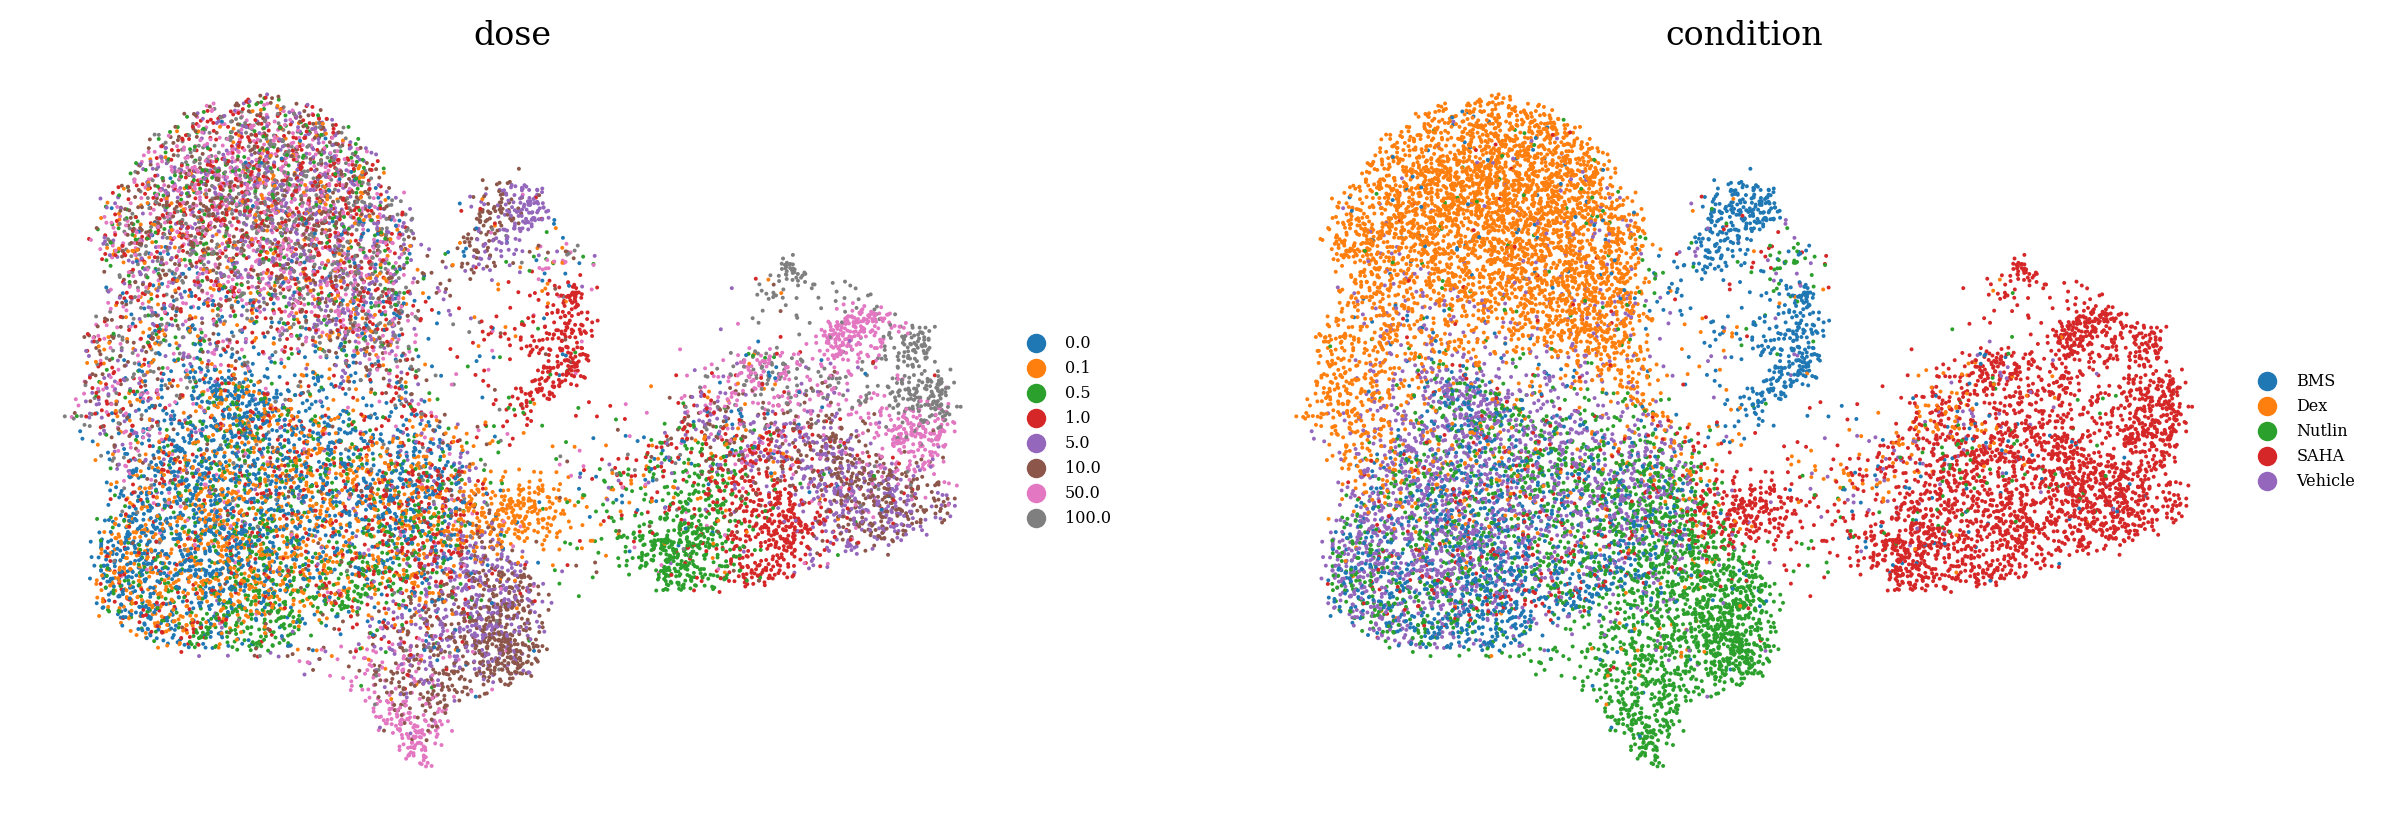

In [20]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

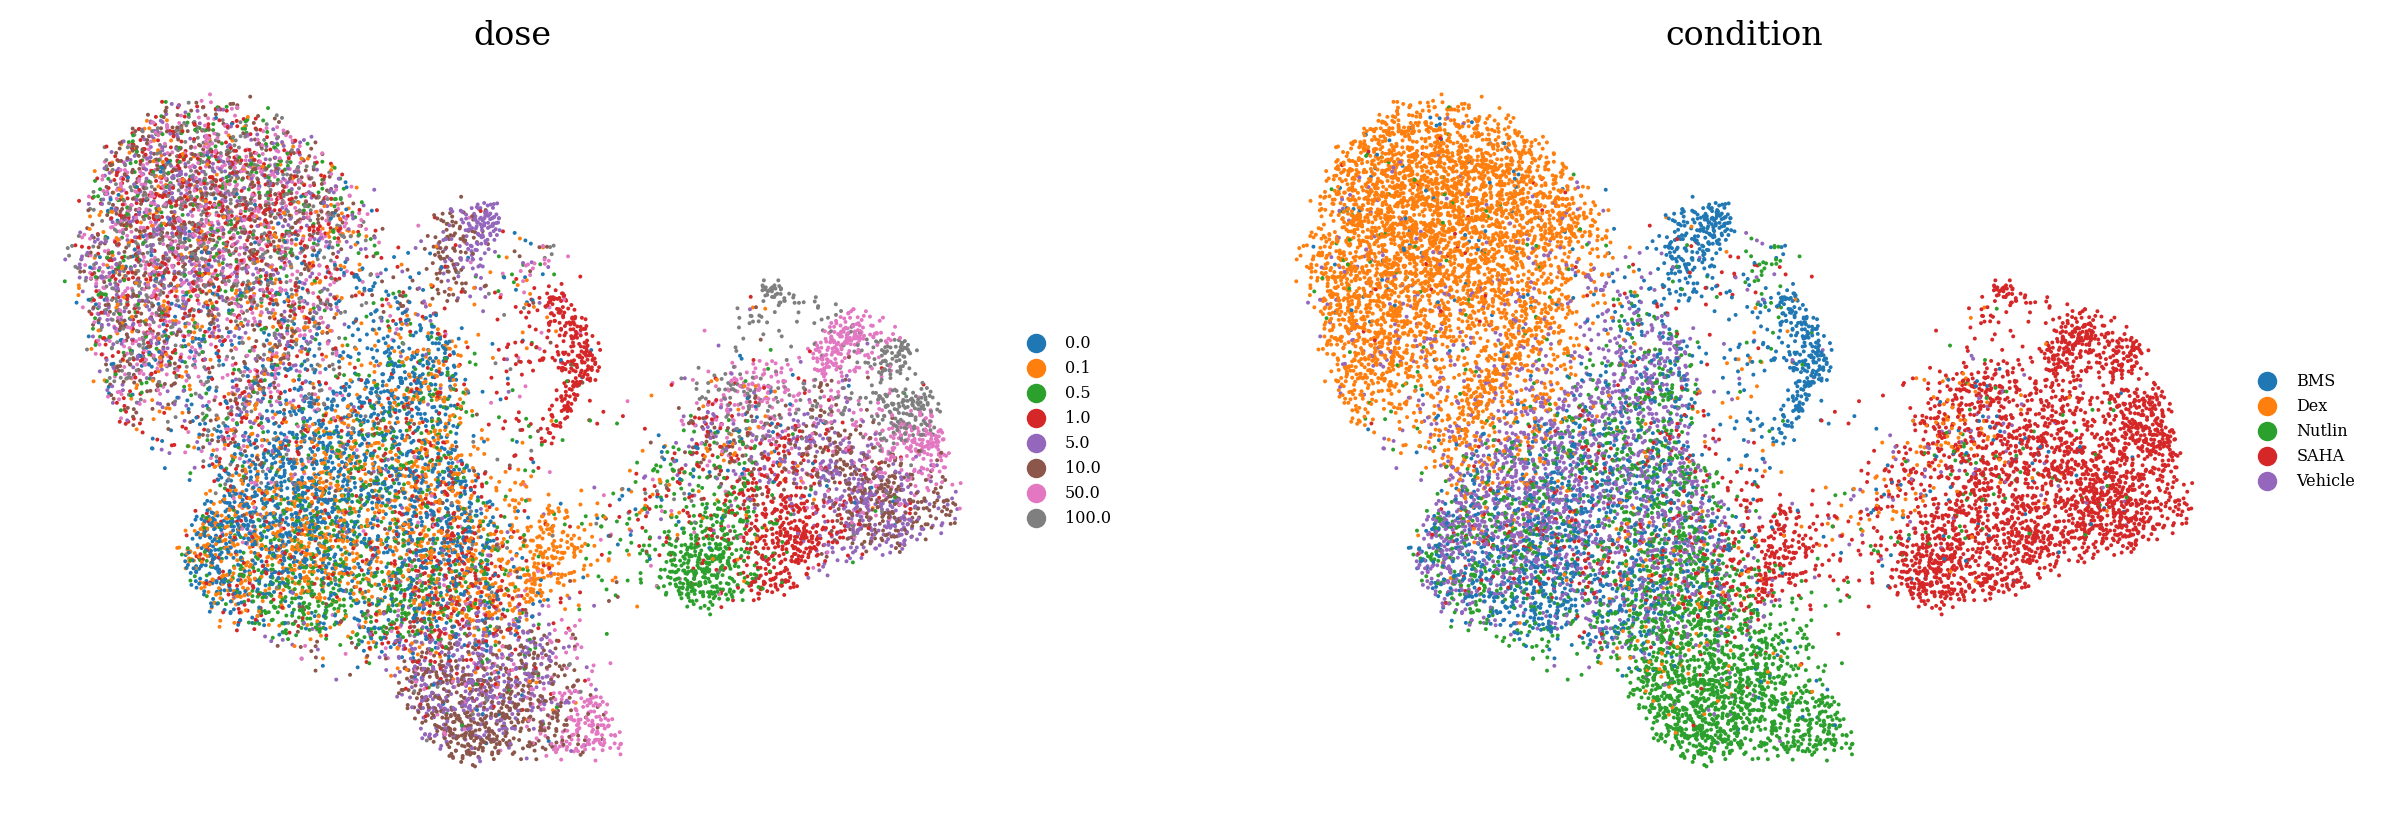

In [21]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["dose", "condition"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [22]:
model.predict()

  0%|          | 0/463 [00:00<?, ?it/s]

  0%|          | 1/463 [00:00<02:26,  3.16it/s]

  5%|▍         | 23/463 [00:00<00:06, 70.46it/s]

 10%|▉         | 44/463 [00:00<00:03, 112.50it/s]

 14%|█▍        | 65/463 [00:00<00:02, 140.29it/s]

 19%|█▊        | 86/463 [00:00<00:02, 159.28it/s]

 24%|██▎       | 109/463 [00:00<00:01, 179.54it/s]

 29%|██▊       | 132/463 [00:00<00:01, 194.31it/s]

 33%|███▎      | 155/463 [00:01<00:01, 203.83it/s]

 38%|███▊      | 178/463 [00:01<00:01, 211.16it/s]

 43%|████▎     | 201/463 [00:01<00:01, 216.25it/s]

 48%|████▊     | 224/463 [00:01<00:01, 219.87it/s]

 53%|█████▎    | 247/463 [00:01<00:00, 222.69it/s]

 58%|█████▊    | 270/463 [00:01<00:00, 224.62it/s]

 63%|██████▎   | 293/463 [00:01<00:00, 215.01it/s]

 68%|██████▊   | 316/463 [00:01<00:00, 218.69it/s]

 73%|███████▎  | 339/463 [00:01<00:00, 221.04it/s]

 78%|███████▊  | 362/463 [00:01<00:00, 223.36it/s]

 83%|████████▎ | 385/463 [00:02<00:00, 224.44it/s]

 88%|████████▊ | 408/463 [00:02<00:00, 184.09it/s]

 93%|█████████▎| 430/463 [00:02<00:00, 192.86it/s]

 98%|█████████▊| 454/463 [00:02<00:00, 203.48it/s]

100%|██████████| 463/463 [00:02<00:00, 186.68it/s]

In [23]:
pred_adata = adata[model.test_indices].copy()
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [24]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.9922642460703065

In [25]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)